In [ ]:
!pip install -q datasets
!pip install -q pytorch-lightning
!pip install -q scikit-learn
!pip install -q transformers
!pip install -q evaluate
!pip install -q hugsvision
!pip install -q piexif

import warnings
import pandas as pd
import numpy as np
import cv2
import torch
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
import transformers
import time
import piexif

#pytorch and pytorch lightning
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy

import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule
from pytorch_lightning.core import datamodule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint


# Vision transfoemer
from transformers import ViTForImageClassification
from transformers import ViTConfig
from transformers import ViTFeatureExtractor
from transformers import ViTImageProcessor

from transformers import pipeline  # What does this do?
from transformers import AutoImageProcessor # Should match dimentions of image -- Need to make my own
from datasets import load_dataset


from torchvision import transforms
import torch.nn as nn

from PIL import Image, ImageEnhance, ImageOps
from sklearn.model_selection import train_test_split

from hugsvision.nnet.VisionClassifierTrainer import VisionClassifierTrainer



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 22.6 MB/s eta 0:00:00


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available():
  print(torch.cuda.device_count())

1


In [ ]:
img_processor = ViTImageProcessor(resample="PIL.Image.BOX", do_normalize=False, image_mean=[0.3, 0.3, 0.3])
img_processor_and_augmentation = ViTImageProcessor()
print(img_processor)
print(img_processor_and_augmentation)

DATASETS

In [ ]:
split = ['train-standard' , 'train-challenge', 'val']
root = "http://places2.csail.mit.edu/download.html"
places365 = torchvision.datasets.Places365(root = 'http://places2.csail.mit.edu/download.html', split = 'train-challenge', small = False, download = False, transform = None, target_transform = None) #, loader = function default_loader)


In [ ]:
root = "http://groups.csail.mit.edu/vision/SUN/"
SUN = torchvision.datasets.SUN397(root = root, transform = None, target_transform = None, download = True)

In [ ]:
class DATASET_LIST(torch.utils.data.Dataset):
    def __init__(self, ds, labels):
        super().__init__()
        self.ds = ds
        self._labels = labels
            
    def __getitem__(self, i):
        return self.ds[i]

    def __len__(self):
        len(self.ds)

SUN_mod = []

for i in range(len(SUN)):

    img, label = SUN[i]
    
    img.getexif().clear()
    SUN_mod.append((img, label))

ds = DATASET_LIST(SUN_mod, SUN._labels)

In [ ]:
# Get information about the sun dataset
print("Type class", type(SUN))
print(SUN.__class__.__name__)
print('Number of samples: ', len(SUN))
print('Root Location: ', SUN.root)
print('Classes: ', SUN.classes)

print('Transforms: ', SUN.transform)
print('Target Transforms: ', SUN.target_transform)

class_inverse = SUN.class_to_idx

# Get the first image in the dataset and its label
img, label = SUN[0]
print(img)
print(type(label))


Type class <class 'torchvision.datasets.sun397.SUN397'>
SUN397
Number of samples:  108754
Root Location:  http://groups.csail.mit.edu/vision/SUN/
Classes:  ['abbey', 'airplane_cabin', 'airport_terminal', 'alley', 'amphitheater', 'amusement_arcade', 'amusement_park', 'anechoic_chamber', 'apartment_building/outdoor', 'apse/indoor', 'aquarium', 'aqueduct', 'arch', 'archive', 'arrival_gate/outdoor', 'art_gallery', 'art_school', 'art_studio', 'assembly_line', 'athletic_field/outdoor', 'atrium/public', 'attic', 'auditorium', 'auto_factory', 'badlands', 'badminton_court/indoor', 'baggage_claim', 'bakery/shop', 'balcony/exterior', 'balcony/interior', 'ball_pit', 'ballroom', 'bamboo_forest', 'banquet_hall', 'bar', 'barn', 'barndoor', 'baseball_field', 'basement', 'basilica', 'basketball_court/outdoor', 'bathroom', 'batters_box', 'bayou', 'bazaar/indoor', 'bazaar/outdoor', 'beach', 'beauty_salon', 'bedroom', 'berth', 'biology_laboratory', 'bistro/indoor', 'boardwalk', 'boat_deck', 'boathouse', '

### Augmentaiton

In [ ]:
class CustomImageProcessor():

    def __init__(self, hparams):
        super().__init__()

        self.hparams = hparams
        size = (224, 448)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        # define transforms for training and validation data
        self.train_transform = transforms.Compose([transforms.Resize(size),  
                                                    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
                                                    transforms.ToTensor(),  
                                                    transforms.Normalize(mean, std)])

        self.val_transform = transforms.Compose([transforms.Resize(size),  
                                                  transforms.ToTensor(),  
                                                  transforms.Normalize(mean, std)])
        
    def __call__(self, images):
        
        return self.train_transform(img)  
        return self.val_transform(img)
 

def inverse(tensor, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

I = CustomImageProcessor(None)
t = I.train_transform
v = I.val_transform
toPIL = transforms.ToPILImage()

In [ ]:
img_processor()

In [ ]:
from PIL import Image

path = '/content/car-oldtimer-vehicle.jpg'

def read_image(path):
    img = Image.open(path)
    return img


img = read_image(path)
print(type(img))


<class 'PIL.JpegImagePlugin.JpegImageFile'>


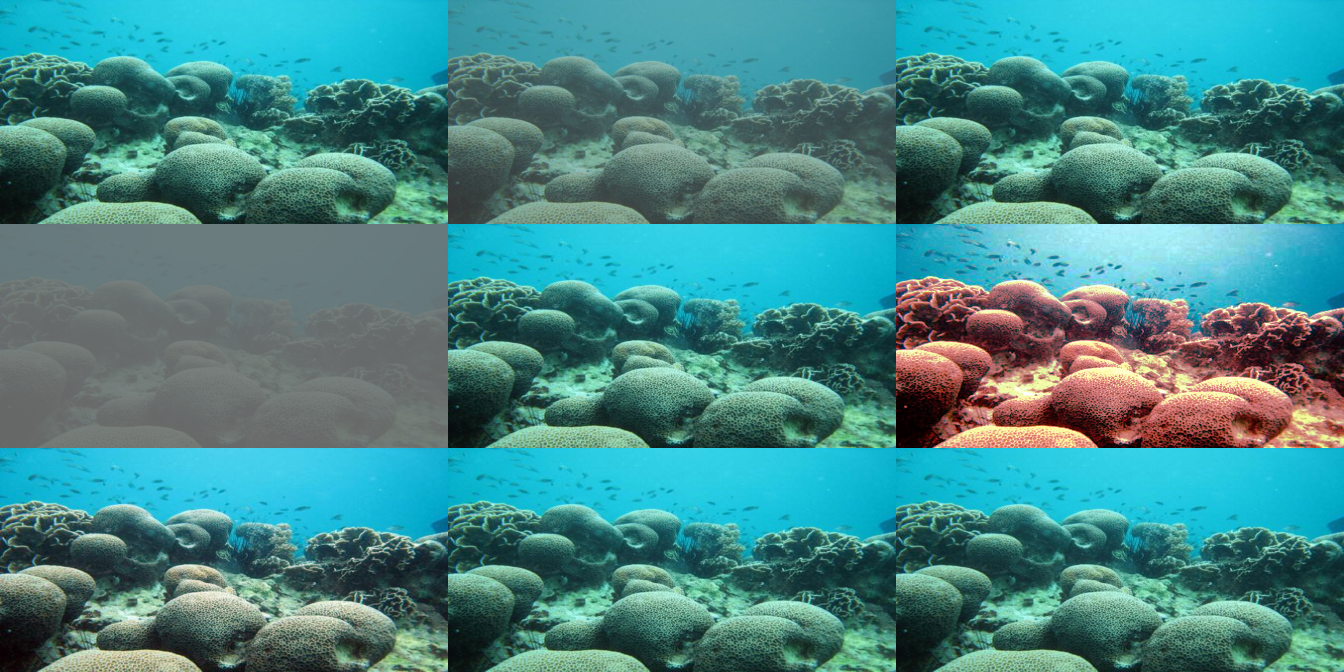

In [ ]:
def show_augmentation(rows=3, cols=3):
    count = rows*cols
    imgs = []
    for i in range(count):
        tensor = t(img) # augmentation
        tensor = inverse(tensor) # denormaization
        pil_img = toPIL(tensor) # from tensor to PIL image
        imgs.append(pil_img)

    grid = image_grid(imgs, rows, cols=3)

    return grid

grid = show_augmentation()
grid

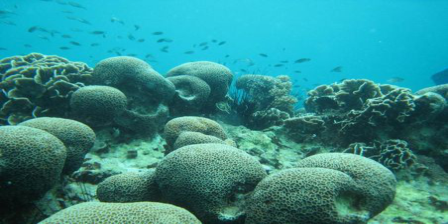

In [ ]:
tensor = v(img)
tensor = inverse(tensor)
pil_img = toPIL(tensor)
pil_img

**The Vision Transformer** was pre-trained using a resolution of 224x224. During fine-tuning, it is often beneficial to use a higher resolution than pre-training (Touvron et al., 2019), (Kolesnikov et al., 2020). In order to **fine-tune at higher resolution**, the authors perform 2D interpolation of the pre-trained position embeddings, according to their location in the original image. How???

**DeiT (Data-efficient Image Transformers)** by Facebook AI. DeiT models are **distilled vision transformers**. The authors of DeiT also released more efficiently trained ViT models, which you can directly plug into ViTModel or ViTForImageClassification. There are 4 variants available (in 3 different sizes): facebook/deit-tiny-patch16-224, facebook/deit-small-patch16-224, facebook/deit-base-patch16-224 and facebook/deit-base-patch16-384. Note that one should use DeiTImageProcessor in order to prepare images for the model.

**BEiT** (BERT pre-training of Image Transformers) by Microsoft Research. BEiT models outperform supervised pre-trained vision transformers using a **self-supervised method** inspired by BERT (masked image modeling) and based on a VQ-VAE.

**DINO (a method for self-supervised training of Vision Transformers)** by Facebook AI. Vision Transformers trained using the DINO method show very interesting properties not seen with convolutional models. They are capable of segmenting objects, without having ever been trained to do so. DINO checkpoints can be found on the hub.

**MAE (Masked Autoencoders) by Facebook AI. By pre-training Vision Transformers to reconstruct pixel values for a high portion (75%) of masked patches** (using an asymmetric encoder-decoder architecture), the authors show that this simple method outperforms supervised pre-training after fine-tuning.

## Dataset splitt

In [ ]:
size = (224, 448)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([transforms.Resize(size),  
                                        transforms.TrivialAugmentWide(num_magnitude_bins = 31),
                                        transforms.ToTensor(),  
                                        transforms.Normalize(mean, std)])

val_transform = transforms.Compose([transforms.Resize(size),  
                                    transforms.ToTensor(),  
                                    transforms.Normalize(mean, std)])

(<PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F1C09C40040>, 189)

In [ ]:
for i in range(796):
    img, label = modified_SUN[i]
    print(i, img.getexif())

time_ = time.time() - start 
print(time_)

In [ ]:
from PIL import Image

modified_SUN = []

def modify_image(image):
    
    data = list(image.getdata())
    image_modified = Image.new(image.mode, image.size)
    image_modified.putdata(data)
    
    return  image_modified

start = time.time()


for i in range(100):
    print(i)
    image, label = SUN[i]
    modified_image = modify_image(image)
    modified_SUN.append((modified_image, label))

time_modified = time.time() - start 
print(time_modified)
#TypeError: 'SUN397' object does not support item assignment

In [ ]:
for i in range(0, 10):
    
    image, label = SUN[i]
    
    print(i, image.getexif())

In [ ]:
def collate_func_train(data):
    
    images, labels = zip(*data)

    #labels = torch.vstack(labels) 
    print(images)
    images = train_transform(images)
    
    return images, labels

In [ ]:


batch_size = 64
targets = SUN._labels
train_idx, valid_idx= train_test_split(np.arange(len(SUN)), test_size=0.2, shuffle=True, stratify=targets)

#train_idx, valid_idx= train_test_split(np.arange(len(SUN)), test_size=0.2, shuffle=True)
SUN_train = TorchDataset(data = SUN, stage = "train")
SUN_val = TorchDataset(data = SUN, stage = "validation")

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(SUN_train, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(SUN_val, batch_size=batch_size, sampler=valid_sampler)



In [ ]:
start = time.time()
X, y = next(iter(train_loader))
time_batch = time.time() - start 
X.shape, y.shape, round(time_batch,3)

(torch.Size([64, 3, 224, 448]), torch.Size([64]), 2.365)

In [ ]:
configuration = ViTConfig(image_size = (224,448))
model = ViTForImageClassification(configuration)
model.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(768, 397), nn.Softmax(dim = -1)) ### chech number of classes!
loss = torch.nn.CrossEntropyLoss()

In [ ]:
tensor = v(img)
t_new = torch.unsqueeze(tensor, dim=0)
with torch.no_grad():
    outputs = model(t_new)

In [ ]:
#model2 = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

Downloading:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
trainer = VisionClassifierTrainer(
	model_name   = "MyKvasirV2Model",
	train        = train,
	test         = test,
	output_dir   = "./out/",
	max_epochs   = 20,
	batch_size   = 32, 
	lr	     = 2e-5,
	fp16	     = True,
	model = ViTForImageClassification()
	feature_extractor = I
)

Linear(in_features=768, out_features=2, bias=True)

In [ ]:
def collate_fn(data):
    
    images, labels = zip(*data)
    
    labels = torch.vstack(labels)

    images = self.train_transform(images)
    
    return images, labels

# Modules pytorch-lightning

In [ ]:
class ViTClassifier(nn.Module):

    def __init__(self, num_labels=397):
        
        super().__init__()

        self.num_labels = num_labels
        self.loss_fn = nn.CrossEntropyLoss()

        configuration = ViTConfig(image_size = (224,448))
        self.model = ViTForImageClassification(configuration)
        self.model.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(768, num_labels)) # nn.Softmax(dim = -1)

    def forward(self, pixel_values, labels):

        logits = self.model(pixel_values=pixel_values)
        
        loss = None
        if labels is not None:
          
          loss = self.loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item()
        else:
          return logits, None

In [ ]:
class TorchDataset(Dataset):
    
    def __init__(self, data = SUN, stage = "train"):

        self.data = data
        size = (224, 448)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        train_transform = transforms.Compose([transforms.Resize(size),  
                                        transforms.TrivialAugmentWide(num_magnitude_bins = 31),
                                        transforms.ToTensor(),  
                                        transforms.Normalize(mean, std)])

        val_transform = transforms.Compose([transforms.Resize(size),  
                                    transforms.ToTensor(),  
                                    transforms.Normalize(mean, std)])

        if stage == "train":
            self.transform = train_transform
        elif stage == "validation":
            self.transform = val_transform
        
        self.target_transform = transforms.ToTensor()

    def __len__(self): # Note that counts for all data! might cause error
        return len(self.data)

    def __getitem__(self, idx):
        
        with warnings.catch_warnings():

            warnings.simplefilter("ignore")

            image, label = self.data[idx]

            image = self.transform(image)

            label = torch.tensor(label, dtype=torch.int64)

        return image, label

In [ ]:
class LightningWrapper(LightningDataModule):


    def __init__(self, data = SUN, batch_size = 32, train_workers = 12, val_workers = 12):
      
        super().__init__()

        self.data = data
        self.batch_size = batch_size
        self.train_workers = train_workers
        self.val_workers = train_workers
        
        targets = self.data._labels
        train_idx, valid_idx= train_test_split(np.arange(len(self.data)), test_size=0.2, shuffle=True, stratify = targets)

        self.train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        self.valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
                                                                  
        self.SUN_train = TorchDataset(data = self.data, stage = "train")
        self.SUN_val = TorchDataset(data = self.data, stage = "validation")

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.SUN_train, batch_size = self.batch_size, sampler = self.train_sampler, num_workers = self.train_workers) # NUM_WORKERS

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.SUN_val, batch_size = self.batch_size, sampler = self.valid_sampler, num_workers = self.val_workers) 



In [ ]:
class VitLightningModule(pl.LightningModule):
    def __init__(self, num_labels = 397, lr = 1.58489e-05):
        super().__init__()
        
        self.save_hyperparameters()
        
        self.loss_function = nn.CrossEntropyLoss()

        configuration = ViTConfig(image_size = (224,448))
        self.model = ViTForImageClassification(configuration)
        self.model.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(768, num_labels))

        self.accuracy_top_1 = MulticlassAccuracy(num_classes = self.hparams.num_labels, top_k = 1)
        self.accuracy_top_5 = MulticlassAccuracy(num_classes = self.hparams.num_labels, top_k = 5)

    def forward(self, X):
        logits = self.model(X)["logits"]
        return logits

    def training_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = self.loss_function(logits, y)
        self.log("train_loss", loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)

        loss = self.loss_function(logits, y)
        acc1 = self.accuracy_top_1(logits, y)
        acc5 = self.accuracy_top_5(logits, y)

        self.log("Validation_loss", loss, on_epoch=True)
        self.log("Validation_accuracy_1", acc1, on_epoch=True, prog_bar = True)
        self.log("Validation_accuracy_5", acc5, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = self.hparams.lr)

In [ ]:
dataModule = LightningWrapper()
vit = VitLightningModule()

In [ ]:
train_loader = dataModule.train_dataloader()

start = time.time()
X, y = next(iter(train_loader))
time_batch = time.time() - start 
X.shape, y.shape, round(time_batch,3)

(torch.Size([32, 3, 224, 448]), torch.Size([32]), 28.355)

In [ ]:
start = time.time()
output = vit.forward(X)
time_forward = time.time() - start 
round(time_forward, 3)

5.359

In [ ]:
checkpoint_callback = ModelCheckpoint(monitor="val_loss")
# auto_scale_batch_size = None

trainer = Trainer( 
    accelerator="auto",
    fast_dev_run=False,
    overfit_batches=False,
    callbacks=[checkpoint_callback],
    track_grad_norm=2,
    devices=1 if torch.cuda.is_available() else None,   # GPU colab command
    precision=16,
    auto_lr_find = True,  
    gradient_clip_val = 2,
    detect_anomaly = True,
    gradient_clip_algorithm="norm",
    max_epochs = -1,
)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit None Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.tune(vit, dataModule)

INFO:lightning_fabric.accelerators.cuda:You are using a CUDA device ('A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/tuner/lr_finder.py:216: UserWarning: Skipping learning rate finder since `fast_dev_run` is enabled.
  rank_zero_warn("Skipping learning rate finder since `fast_dev_run` is enabled.")


{'lr_find': None}

In [ ]:
trainer.fit(vit, dataModule)

INFO:lightning_fabric.accelerators.cuda:You are using a CUDA device ('A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                      | Params
-------------------------------------------------------------
0 | loss_function  | CrossEntropyLoss          | 0     
1 | model          | ViTForImageClassification | 86.3 M
2 | accuracy_top_1 | MulticlassAccuracy        | 0     
3 | accuracy_top_5 | MulticlassAccuracy        | 0     
-------------------------------------------------------------
86.3 M    Trainable params
0         Non-trainable params
86.3 M    To

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
trainer.validate(vit, dataModule)

INFO:lightning_fabric.accelerators.cuda:You are using a CUDA device ('A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Accuracy_1          0.014347073622047901
       Accuracy_5           0.03281332552433014
     Validation_loss        3.6744000911712646
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'Validation_loss': 3.6744000911712646,
  'Accuracy_1': 0.014347073622047901,
  'Accuracy_5': 0.03281332552433014}]